In [1]:
!ls 

Fairness_on_Regression_Tasks.ipynb data_exploration.ipynb
README.md                          dataset-cleaning.ipynb
data                               ml_curated_data


In [2]:
!ls data/*

data/communities.data
data/communities.names
data/communities_and_crime.csv
data/communities_and_crime_clean.csv
data/communities_and_crime_cleaner_no_unknowns.csv


In [1]:
import tensorflow as tf
import pandas as pd
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.5f}'.format
tf.logging.set_verbosity(tf.logging.ERROR)
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import keras

from keras.layers import Dense
from keras import optimizers
from numpy.polynomial.polynomial import polyfit
import numpy as np

from keras.layers import Input, Dense
from keras.models import Model
from keras import backend as K

from tensorflow.python.data import Dataset
from sklearn import metrics
tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


In [4]:
data = pd.read_csv("data/communities_and_crime_clean.csv")

In [5]:
data.head()

,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,1,0.19000,0.33000,0.02000,0.90000,0.12000,0.17000,0.34000,0.47000,0.29000,...,0.12000,0.42000,0.50000,0.51000,0.64000,0.12000,0.26000,0.20000,0.32000,0.20000
1,1,0.00000,0.16000,0.12000,0.74000,0.45000,0.07000,0.26000,0.59000,0.35000,...,0.21000,0.50000,0.34000,0.60000,0.52000,0.02000,0.12000,0.45000,0.00000,0.67000
2,1,0.00000,0.42000,0.49000,0.56000,0.17000,0.04000,0.39000,0.47000,0.28000,...,0.14000,0.49000,0.54000,0.67000,0.56000,0.01000,0.21000,0.02000,0.00000,0.43000
3,1,0.04000,0.77000,1.00000,0.08000,0.12000,0.10000,0.51000,0.50000,0.34000,...,0.19000,0.30000,0.73000,0.64000,0.65000,0.02000,0.39000,0.28000,0.00000,0.12000
4,1,0.01000,0.55000,0.02000,0.95000,0.09000,0.05000,0.38000,0.38000,0.23000,...,0.11000,0.72000,0.64000,0.61000,0.53000,0.04000,0.09000,0.02000,0.00000,0.03000


In [6]:
data.shape

(1994, 101)

In [7]:
data.to_csv("data/communities_and_crime_cleaner_no_unknowns.csv")

In [8]:
def train_test_split(data, folds=[10]):
    folds = set(folds)
    training_data = data.copy()
    test_data = None
    for fold_number in folds:
        training_data = training_data[training_data.fold != fold_number]
        new_test_data = data[data.fold == fold_number]
        if test_data is None:
            test_data = new_test_data
        else:
            test_data = pd.concat([test_data, new_test_data])
    return training_data, test_data

In [9]:
training_data, test_data = train_test_split(data, folds=[10])

In [10]:
training_data.shape,test_data.shape

((1795, 101), (199, 101))

In [11]:
training_data.describe()

,fold,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
count,1795.00000,1795.00000,1795.00000,1795.00000,1795.00000,1795.00000,1795.00000,1795.00000,1795.00000,1795.00000,...,1795.00000,1795.00000,1795.00000,1795.00000,1795.00000,1795.00000,1795.00000,1795.00000,1795.00000,1795.00000
mean,4.99443,0.05714,0.46432,0.17949,0.75329,0.15374,0.14490,0.42489,0.49388,0.33678,...,0.21590,0.60812,0.53499,0.62622,0.65119,0.06529,0.23136,0.16296,0.09469,0.23915
std,2.58306,0.12531,0.16463,0.25386,0.24489,0.20809,0.23371,0.15645,0.14433,0.16816,...,0.23148,0.20476,0.18160,0.20125,0.19869,0.10789,0.20144,0.22988,0.24097,0.23554
min,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,3.00000,0.01000,0.35000,0.02000,0.63000,0.04000,0.01000,0.33000,0.41000,0.25000,...,0.06000,0.47000,0.42000,0.53000,0.56000,0.02000,0.10000,0.02000,0.00000,0.07000
50%,5.00000,0.02000,0.44000,0.06000,0.85000,0.08000,0.04000,0.40000,0.47000,0.29000,...,0.13000,0.63000,0.55000,0.67000,0.70000,0.04000,0.17000,0.07000,0.00000,0.15000
75%,7.00000,0.05000,0.54000,0.23000,0.94000,0.17000,0.16000,0.47000,0.54000,0.36000,...,0.28000,0.77500,0.66000,0.77000,0.79000,0.07000,0.28000,0.19000,0.00000,0.33000
max,9.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000,...,1.00000,1.00000,0.99000,0.99000,1.00000,1.00000,1.00000,1.00000,1.00000,1.00000


In [12]:
test_data.describe()

KeyboardInterrupt: 

### Violent crimes per population 

In [ ]:

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(131)
ax.set_title("Training Data - racePctWhite vs racePctBlack")
ax.set_autoscaley_on(False)
ax.set_ylim([0, 1])
ax.set_autoscalex_on(False)
ax.set_xlim([0, 1])

ax.set_xlabel("racepctblack")
ax.set_ylabel("racePctWhite")

plt.scatter(training_data['racepctblack'],training_data['racePctWhite'], cmap='coolwarm', c=training_data['ViolentCrimesPerPop'])

ax = plt.subplot(1, 3, 2)
ax.set_title("Training Data - racePctWhite vs racePctAsian")
ax.set_autoscaley_on(False)
ax.set_ylim([0, 1])
ax.set_autoscalex_on(False)
ax.set_xlim([0, 1])

ax.set_xlabel("racepctAsian")
ax.set_ylabel("racePctWhite")

plt.scatter(training_data['racePctAsian'], training_data['racePctWhite'], cmap='coolwarm', c=training_data['ViolentCrimesPerPop'])

ax = plt.subplot(1, 3, 3)
ax.set_title("Training Data - racePctWhite vs racePctHispanic")
ax.set_autoscaley_on(False)
ax.set_ylim([0, 1])
ax.set_autoscalex_on(False)
ax.set_xlim([0, 1])

plt.scatter(training_data['racePctHisp'], training_data['racePctWhite'], cmap='coolwarm', c=training_data['ViolentCrimesPerPop'])
ax.set_xlabel("racepctHisp")
ax.set_ylabel("racePctWhite")


## For validation data


fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(131)
ax.set_title("Test Data - racePctWhite vs racePctBlack")
ax.set_autoscaley_on(False)
ax.set_ylim([0, 1])
ax.set_autoscalex_on(False)
ax.set_xlim([0, 1])

ax.set_xlabel("racepctblack")
ax.set_ylabel("racePctWhite")

plt.scatter(test_data['racepctblack'],test_data['racePctWhite'], cmap='coolwarm', c=test_data['ViolentCrimesPerPop'])

ax = plt.subplot(1, 3, 2)
ax.set_title("Test Data - racePctWhite vs racePctAsian")
ax.set_autoscaley_on(False)
ax.set_ylim([0, 1])
ax.set_autoscalex_on(False)
ax.set_xlim([0, 1])

ax.set_xlabel("racepctAsian")
ax.set_ylabel("racePctWhite")

plt.scatter(test_data['racePctAsian'], test_data['racePctWhite'], cmap='coolwarm', c=test_data['ViolentCrimesPerPop'])

ax = plt.subplot(1, 3, 3)
ax.set_title("Test Data - racePctWhite vs racePctHisp")
ax.set_autoscaley_on(False)
ax.set_ylim([0, 1])
ax.set_autoscalex_on(False)
ax.set_xlim([0, 1])

plt.scatter(test_data['racePctHisp'], test_data['racePctWhite'], cmap='coolwarm', c=test_data['ViolentCrimesPerPop'])
ax.set_xlabel("racepctHisp")
ax.set_ylabel("racePctWhite")

### Train model on the data

In [ ]:
VIOLENT_CRIMES_PER_POP = "ViolentCrimesPerPop"
FOLD = "fold"
test_targets =pd.DataFrame()
training_input, training_targets = training_data.drop([FOLD, VIOLENT_CRIMES_PER_POP], axis=1), training_data[VIOLENT_CRIMES_PER_POP]
test_input, test_targets[VIOLENT_CRIMES_PER_POP] = test_data.drop([FOLD, VIOLENT_CRIMES_PER_POP], axis=1), test_data[VIOLENT_CRIMES_PER_POP]

In [ ]:
training_input.keys()

In [ ]:
test_input.shape, test_targets.shape

### Attempt 1: Keras model

In [ ]:
INPUT_SIZE = len(training_input.keys())

In [ ]:

def build_model():
    model = keras.Sequential([
        Dense(64, activation='relu', input_shape=[INPUT_SIZE]),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    
    rmsprop = keras.optimizers.RMSprop(0.001)
    sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss='mse', optimizer = sgd,  metrics=['mae', 'mse'])
    return model
    
model = build_model()
model.summary()
    

In [ ]:
example_batch = training_input[:10]
example_output = model.predict(example_batch)

In [ ]:
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(131)
ax.set_title("True value vs untrained output")
plt.scatter(training_targets[:10], example_output[:10])
plt.xlabel("True Value")
plt.ylabel("Untrained output")

In [ ]:
class PrintProgress(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: 
            print('')
        print('.', end='')
            
EPOCHS = 100

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(
    training_input, training_targets, epochs=EPOCHS, validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintProgress()])

In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

In [ ]:
example_batch = training_input[:100]
example_output = model.predict(example_batch)
example_true_output = training_targets[:10]

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(131)
ax.set_title("True value vs Trained output")
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.scatter(training_targets[:100], example_output[:100])
plt.xlabel("True Value")
plt.ylabel("Prediction")

In [ ]:
def plot_history(history):
    MAE = 'mean_absolute_error'
    VAL_MAE='val_mean_absolute_error'
    MSE="mean_squared_error"
    VAL_MSE = "val_mean_squared_error"
    
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist[MAE],
             label='Train Error')
    plt.plot(hist['epoch'], hist[VAL_MAE],
           label = 'Val Error')
    
    plt.ylim([0,0.3])
    plt.legend()
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist[MSE],
           label='Train Error')
    plt.plot(hist['epoch'], hist[VAL_MSE],
           label = 'Val Error')
    plt.ylim([0,0.3])
    plt.legend()
    plt.show()

plot_history(history)

In [ ]:
loss, mae, mse = model.evaluate(test_input, test_targets, verbose=2)

In [ ]:
print("Testing set Mean Abs Error: {:5.2f} ".format(mae))

In [ ]:
test_predictions = model.predict(test_input)
plt.scatter(test_targets, test_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-2, 2], [-2, 2])

In [ ]:
error = test_predictions.reshape(199) - test_targets
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error ( ViolentCrimes Per Pop)")
_ = plt.ylabel("Count")
plt.show()

##### Error follows gaussian distribution

In [ ]:
### Bias analysis on test data


In [ ]:
test_input.describe()

In [ ]:
error.describe()

In [ ]:
test_targets.shape

# Evaluate Estimation Error coefficient ( Group Fairness) 

In [ ]:
ERROR_LABEL = 'Error [Crime Rate Per Population]'

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(141)
ax.set_title("Test Data - Error racePctWhite")

ax.set_xlabel("racePctWhite")
ax.set_ylabel(ERROR_LABEL)
plt.scatter(test_data.racePctWhite,error)
b, m = polyfit(test_data.racePctWhite, error, 1)
plt.plot(test_data.racePctWhite,  b + m *test_data.racePctWhite, '-')

ax = plt.subplot(142)
ax.set_title("Test Data - Error vs racePctBlack")

ax.set_xlabel("racePctBlack")
ax.set_ylabel(ERROR_LABEL)
plt.scatter(test_data.racepctblack, error)
b, m = polyfit(test_data.racepctblack, error, 1)
plt.plot(test_data.racepctblack,  b + m *test_data.racepctblack, '-')

ax = plt.subplot(143)
ax.set_title("Test Data - Error vs racePctAsian")
plt.scatter(test_data.racePctAsian, error)
ax.set_xlabel("racepctAsian")
ax.set_ylabel(ERROR_LABEL)
b, m = polyfit(test_data.racePctAsian, error, 1)
plt.plot(test_data.racePctAsian,  b + m *test_data.racePctAsian, '-')
              
ax = plt.subplot(144)
ax.set_title("Test Data - Error vs racepctHisp")
plt.scatter(test_data.racePctHisp, error)
ax.set_xlabel("racepctHisp")
ax.set_ylabel(ERROR_LABEL)
b, m = polyfit(test_data.racePctHisp, error, 1)
plt.plot(test_data.racePctHisp,  b + m *test_data.racePctHisp, '-')

##### Results: We see negative coefficients for racePctWhite, racePctAsian and racePctHispanic, while we see positive coefficient for racePctBlack.

In [ ]:
ERROR_LABEL = 'Abs(Error) [Crime Rate Per Population]'
abs_error = np.abs(error)

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(141)
ax.set_title("Test Data - abs(Error) vs racePctWhite")

ax.set_xlabel("racePctWhite")
ax.set_ylabel(ERROR_LABEL)
plt.scatter(test_data.racePctWhite,abs_error)
b, m = polyfit(test_data.racePctWhite, abs_error, 1)
plt.plot(test_data.racePctWhite,  b + m *test_data.racePctWhite, '-')

ax = plt.subplot(142)
ax.set_title("Test Data - abs(Error) vs racePctBlack")

ax.set_xlabel("racePctBlack")
ax.set_ylabel(ERROR_LABEL)
plt.scatter(test_data.racepctblack, abs_error)
b, m = polyfit(test_data.racepctblack, abs_error, 1)
plt.plot(test_data.racepctblack,  b + m *test_data.racepctblack, '-')

ax = plt.subplot(143)
ax.set_title("Test Data - abs(Error) vs racePctAsian")
plt.scatter(test_data.racePctAsian, abs_error)
ax.set_xlabel("racepctAsian")
ax.set_ylabel(ERROR_LABEL)
b, m = polyfit(test_data.racePctAsian, abs_error, 1)
plt.plot(test_data.racePctAsian,  b + m *test_data.racePctAsian, '-')
              
ax = plt.subplot(144)
ax.set_title("Test Data - abs(Error) vs racePctHispanic")
plt.scatter(test_data.racePctHisp, abs_error)
ax.set_xlabel("racepctHisp")
ax.set_ylabel(ERROR_LABEL)
b, m = polyfit(test_data.racePctHisp, abs_error, 1)
plt.plot(test_data.racePctHisp,  b + m *test_data.racePctHisp, '-')

## Evaluate consistency ( Individual Fairness)

In [ ]:
def euclidean_distance(vec1, vec2):
    diff = vec1 - vec2
    out = np.sqrt(np.dot(diff, diff.T))
    return out

def get_prediction_difference(input_dataset):
    predictions = model.predict(input_dataset)
    difference_matrix = None

def cosine_distance(vec1, vec2):
    # TODO(audace) Implement cosine distance
    pass

In [ ]:
# TODO(audace): Vectorize
test_input_np = np.array(test_input)
test_input_np.shape
n_rows = test_input.shape[0]
results_list = [[], []]
for index_1 in range(n_rows):
    for index_2 in range(n_rows):
        vec1 = test_input_np[index_1,:].reshape((1, 99))
        vec2 = test_input_np[index_2, :].reshape((1, 99))
        distance = euclidean_distance(vec1, vec2)
        prediction_difference = np.abs(model.predict(vec1) - model.predict(vec2)).reshape((1,))
        results_list[0].append(distance.flatten()[0])
        results_list[1].append(prediction_difference.flatten()[0])

# Consistency of prediction

In [ ]:
plt.figure()
plt.scatter(results_list[0], results_list[1])
plt.xlabel("Euclidean distance")
plt.ylabel("Prediction Difference")

In [ ]:
# Consistency of error

In [ ]:
error_as_list = list(error)

In [ ]:
# TODO(audace): Vectorize
test_input_np = np.array(test_input)
test_input_np.shape
n_rows = test_input.shape[0]
results_list = [[], []]
for index_1 in range(n_rows):
    for index_2 in range(n_rows):
        vec1 = test_input_np[index_1,:].reshape((1, 99))
        vec2 = test_input_np[index_2, :].reshape((1, 99))
        distance = euclidean_distance(vec1, vec2)
        error_difference = np.abs(error_as_list[index_1] - error_as_list[index_2])
        results_list[0].append(distance.flatten()[0])
        results_list[1].append(error_difference.flatten()[0])

In [ ]:
plt.figure()
plt.scatter(results_list[0], results_list[1])
plt.xlabel("Euclidean distance")
plt.ylabel("Error Difference")

### Architecture 2: Linear regressor with tensorflow.estimator.LinearRegressor

In [ ]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    ## Convert data into a dict of np array
    features = {key: np.array(value) for key, value in dict(features).items()}
    
    ## Construct dataset, and consider batching and repeating
    ds = Dataset.from_tensor_slices((features, targets)) # 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds = ds.shuffle(100)
        
    # Return the next batch of data
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

def construct_feature_columns(input_features):
    """
    features: the names of numerical features to use
    Returns a set of feature column
    """
    return set([tf.feature_column.numeric_column(my_feature) for my_feature in input_features])

def train_model(learning_rate, steps, batch_size, training_examples, training_targets, validation_examples, validation_targets):
    
    """Trains a linear regression model of multiple features.
    
    In addition to training, this function also prints training progress information, as well as a plot of the training and validation loss over time.
    
    Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
    Returns:
    A `LinearRegressor` object trained on the training data.
    """
    periods = 15
    print("Periods: ", periods)
    steps_per_period = steps/periods
    
    
    # Create a linear regression object
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(feature_columns=construct_feature_columns(training_examples), optimizer=my_optimizer)
    
    
    
    training_input_fn = lambda: my_input_fn(training_examples, training_targets[VIOLENT_CRIMES_PER_POP], batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, training_targets[VIOLENT_CRIMES_PER_POP], num_epochs=1, shuffle=False)
    predict_validation_input_fn = lambda : my_input_fn(validation_examples, validation_targets[VIOLENT_CRIMES_PER_POP], num_epochs=1, shuffle=False)
    
    print("Training model ..... ")
    print("RMSE on the data .... ")
    training_rmse = []
    validation_rmse = []
    
    for period in range(0, periods):
        # train the model, starting from the prior state
        linear_regressor.train(input_fn = training_input_fn, steps=steps_per_period)
        
        # Take a break and compute predictions
        training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        
        validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
        
        
        
        ## Compute training and validation loss
        training_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(validation_predictions, validation_targets))
        
        ## Occasionally print the current loss
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
        
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
        
    print("Model training finished.")
    
     # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()
    
    return linear_regressor
    

In [ ]:
new_training_data, new_validation_data = train_test_split(training_data, folds =[5])
assert new_training_data.shape[0] > 0 and new_validation_data.shape[0]  > 0

new_training_targets, new_validation_targets = pd.DataFrame(), pd.DataFrame()
new_training_examples, new_training_targets[VIOLENT_CRIMES_PER_POP] = new_training_data.drop([FOLD, VIOLENT_CRIMES_PER_POP], axis=1), new_training_data[VIOLENT_CRIMES_PER_POP]
new_validation_examples, new_validation_targets[VIOLENT_CRIMES_PER_POP] = new_validation_data.drop([FOLD, VIOLENT_CRIMES_PER_POP], axis=1), new_validation_data[VIOLENT_CRIMES_PER_POP]



In [ ]:
linear_regressor = train_model(learning_rate =0.001, steps=100, batch_size=8, training_examples=new_training_examples, training_targets=new_training_targets, validation_examples=new_validation_examples, validation_targets=new_validation_targets)

### Some results summary:

- lr = 0.001, batch_size = 8, periods = 10 : rmse = 0.19 or 0.18
- lr = 0.001, batch_size = 8, periods = 30: rmse = 0.17
- lr = 0.001, batch_size = 8, periods = 50: rmse = 0.21



In [ ]:
# Run on test data
test_input_fn = lambda: my_input_fn(test_input, test_targets, batch_size=1, shuffle=False)
test_predictions = linear_regressor.predict(input_fn = test_input_fn)

predict_test_input_fn = lambda: my_input_fn(test_input, test_targets, num_epochs=1, shuffle=False)

test_predictions = linear_regressor.predict(input_fn=predict_test_input_fn)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(metrics.mean_squared_error(test_predictions, test_targets))
print("Final RMSE (on test data): %0.2f" % root_mean_squared_error)


In [ ]:
new_error = test_predictions - test_targets

ERROR_LABEL = 'Error [Crime Rate Per Population]'

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(141)
ax.set_title("Test Data - Error racePctWhite")

ax.set_xlabel("racePctWhite")
ax.set_ylabel(ERROR_LABEL)
plt.scatter(test_input.racePctWhite,new_error)
b, m = polyfit(test_input.racePctWhite, new_error, 1)
plt.plot(test_input.racePctWhite,  b + m *test_input.racePctWhite, '-')

ax = plt.subplot(142)
ax.set_title("Test Data - Error vs racePctBlack")

ax.set_xlabel("racePctBlack")
ax.set_ylabel(ERROR_LABEL)
plt.scatter(test_input.racepctblack, new_error)
b, m = polyfit(test_input.racepctblack, new_error, 1)
plt.plot(test_input.racepctblack,  b + m *test_input.racepctblack, '-')

ax = plt.subplot(143)
ax.set_title("Test Data - Error vs racePctAsian")
plt.scatter(test_input.racePctAsian, new_error)
ax.set_xlabel("racepctAsian")
ax.set_ylabel(ERROR_LABEL)
b, m = polyfit(test_input.racePctAsian, new_error, 1)
plt.plot(test_input.racePctAsian,  b + m *test_input.racePctAsian, '-')
              
ax = plt.subplot(144)
ax.set_title("Test Data - Error vs racepctHisp")
plt.scatter(test_input.racePctHisp, new_error)
ax.set_xlabel("racepctHisp")
ax.set_ylabel(ERROR_LABEL)
b, m = polyfit(test_input.racePctHisp, new_error, 1)
plt.plot(test_input.racePctHisp,  b + m *test_input.racePctHisp, '-')

In [ ]:


fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(131)
ax.set_title("Predicted output vs True value")
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.scatter(test_targets, test_predictions)
plt.xlabel("True value")
plt.ylabel("Predictions")

### Appendix:  Related works
- [Fairness-Aware learning for continuous attributes and treatment](http://proceedings.mlr.press/v97/mary19a/mary19a-supp.pdf)

- [A convex framework for fair regression](https://arxiv.org/abs/1706.02409)

#### Checkpoint data so far

In [ ]:
new_validation_examples.head()

In [ ]:
test_targets.shape

In [ ]:
new_validation_examples.to_csv('ml_curated_data/validation_examples.csv', index=False)
new_validation_targets.to_csv('ml_curated_data/validation_targets.csv', index=False)
test_input.to_csv('ml_curated_data/test_examples.csv', index=False)
test_targets.to_csv('ml_curated_data/test_targets.csv', index=False)
new_training_examples.to_csv("ml_curated_data/training_examples.csv", index=False)
new_training_targets.to_csv("ml_curated_data/training_targets.csv", index=False)


In [ ]:
test_input.shape, test_targets.shape

# Implement residual model with debiasing

In [2]:
training_examples_3 = pd.read_csv('ml_curated_data/training_examples.csv')
training_targets_3 = pd.read_csv('ml_curated_data/training_targets.csv')
validation_examples_3 = pd.read_csv('ml_curated_data/validation_examples.csv')
validation_targets_3 = pd.read_csv('ml_curated_data/validation_targets.csv')
test_examples_3 = pd.read_csv('ml_curated_data/test_examples.csv')
test_targets_3 = pd.read_csv('ml_curated_data/test_targets.csv')

In [3]:
test_targets_3.shape

(199, 1)

In [4]:
test_examples_3.shape, test_targets_3.shape

((199, 99), (199, 1))

In [13]:
def CC(y_true, y_pred):
    """
    Return differentible correlation coefficient
    """
    #normalise
    n_y_true = (y_true - K.mean(y_true[:])) / K.std(y_true[:])
    n_y_pred = (y_pred - K.mean(y_pred[:])) / K.std(y_pred[:])  

    top=K.sum((n_y_true[:]-K.mean(n_y_true[:]))*(n_y_pred[:]-K.mean(n_y_pred[:])),axis=[-1,-2])
    bottom=K.sqrt(K.sum(K.pow((n_y_true[:]-K.mean(n_y_true[:])),2),axis=[-1,-2])*K.sum(K.pow(n_y_pred[:]-K.mean(n_y_pred[:]),2),axis=[-1,-2]))

    result=top/bottom


    return K.mean(result)

In [6]:


def build_residual_model(input_shape, if_loss=True, gf_loss=True):
    
    ## Pre-repr layers
    input_layer = Input(shape=input_shape)
    pre_dense_1 = Dense(128, activation='relu')(input_layer)
    pre_dense_2 = Dense(64, activation='relu')(pre_dense_1)
    
    repr_layer = Dense(32, activation='relu')(pre_dense_2)
    
    # Post-repr layers
    post_dense_1 = Dense(128, activation='relu')(repr_layer)
    post_dense_2 = Dense(64, activation='relu')(post_dense_1)
    post_dense_3 = Dense(32, activation='relu')(post_dense_2)
    output = Dense(1, activation='relu')(post_dense_3)
    
    def fairness_loss_function(_input_layer, _repr_layer):
        """
        ypred and y_true are mini-batches of [m x 1]
        """
        def fairness_loss_function(ytrue, ypred):
            accuracy_loss = keras.losses.mse(ytrue, ypred)
            
            # TODO(audace): Complete implementation of pearson coefficient loss for group fairness
            pearson_coefficient_loss = 0
            
            # Compute pairwise euclidean distnces, Source: (https://stackoverflow.com/questions/37009647/compute-pairwise-distance-in-a-batch-without-replicating-tensor-in-tensorflow)
            # Compute euclidean distance
            A = repr_layer
            r = K.mean(A, 1)
            r = K.reshape(r, [-1, 1])
            D = r - 2*K.dot(A, K.transpose(A)) + K.transpose(r)
            
            error = ypred - ytrue
            # similarity error correlation            
            similarity_metric_loss = 0.2 * K.abs(CC(error, D))
            return accuracy_loss + pearson_coefficient_loss + similarity_metric_loss
        return fairness_loss_function
    model = Model(input_layer, output)
    rmsprop_optimizer = keras.optimizers.RMSprop(0.001)
    model.compile(optimizer=rmsprop_optimizer, loss=fairness_loss_function(input_layer, repr_layer))
    return model

In [7]:
model = build_residual_model([validation_examples_3.shape[1]])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 99)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               12800     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
__________

### Run on untrained predictions

Text(0, 0.5, 'Prediction')

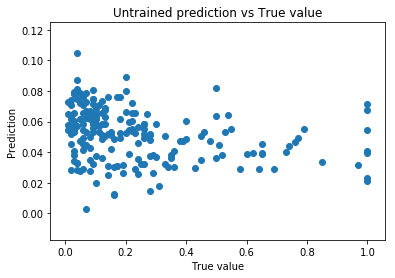

In [8]:
validation_predictions_3_before_training = model.predict(validation_examples_3)
plt.scatter(validation_targets_3, validation_predictions_3_before_training)
plt.title("Untrained prediction vs True value")
plt.xlabel("True value")
plt.ylabel("Prediction")

## Train the model

In [9]:
model.fit(training_examples_3, training_targets_3, batch_size=8, epochs=100)

Epoch 1/100
1596/1596 [==============================] - 1s 561us/step - loss: 0.1755
Epoch 2/100
1596/1596 [==============================] - 0s 242us/step - loss: 0.1446
Epoch 3/100
1596/1596 [==============================] - 0s 235us/step - loss: 0.1228
Epoch 4/100
1596/1596 [==============================] - 0s 228us/step - loss: 0.1232
Epoch 5/100
1596/1596 [==============================] - 0s 224us/step - loss: 0.1114
Epoch 6/100
1596/1596 [==============================] - 0s 246us/step - loss: 0.1067
Epoch 7/100
1596/1596 [==============================] - 0s 226us/step - loss: 0.1038
Epoch 8/100
1596/1596 [==============================] - 0s 215us/step - loss: 0.1042
Epoch 9/100
1596/1596 [==============================] - 0s 242us/step - loss: 0.0935
Epoch 10/100
1596/1596 [==============================] - 0s 234us/step - loss: 0.0913
Epoch 11/100
1596/1596 [==============================] - 0s 263us/step - loss: 0.0949
Epoch 12/100
1596/1596 [============================

1596/1596 [==============================] - 0s 252us/step - loss: 0.0670
Epoch 96/100
1596/1596 [==============================] - 0s 223us/step - loss: 0.0639
Epoch 97/100
1596/1596 [==============================] - 0s 247us/step - loss: 0.0610
Epoch 98/100
1596/1596 [==============================] - 0s 230us/step - loss: 0.0704
Epoch 99/100
1596/1596 [==============================] - 0s 237us/step - loss: 0.0682
Epoch 100/100
1596/1596 [==============================] - 0s 246us/step - loss: 0.0733


## Run on trained model

Text(0, 0.5, 'Prediction')

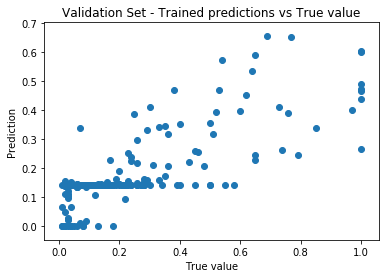

In [10]:
validation_predictions_3_before_training = model.predict(validation_examples_3)
plt.scatter(validation_targets_3, validation_predictions_3_before_training)
plt.title("Validation Set - Trained predictions vs True value")
plt.xlabel("True value")
plt.ylabel("Prediction")

Text(0, 0.5, 'Prediction')

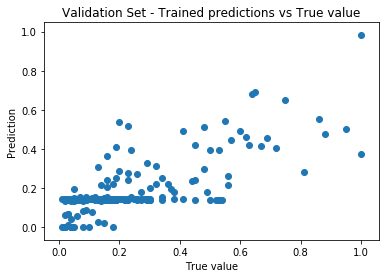

In [11]:
test_predictions_3_after_training = model.predict(test_examples_3)
plt.scatter(test_targets_3, test_predictions_3_after_training)
plt.title("Validation Set - Trained predictions vs True value")
plt.xlabel("True value")
plt.ylabel("Prediction")

### Run bias analytics

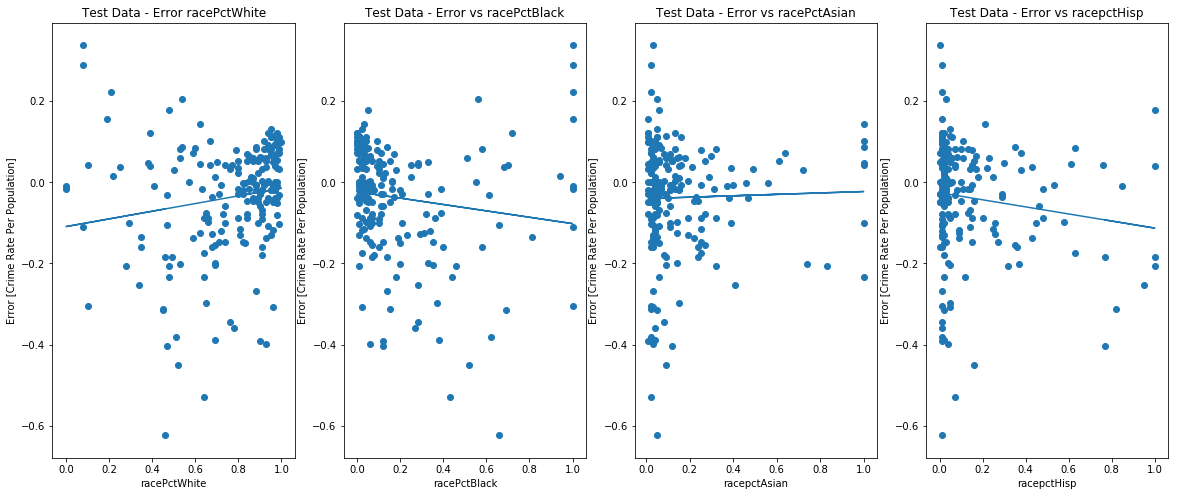

In [12]:
new_error = test_predictions_3_after_training - test_targets_3

ERROR_LABEL = 'Error [Crime Rate Per Population]'

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(141)
ax.set_title("Test Data - Error racePctWhite")

ax.set_xlabel("racePctWhite")
ax.set_ylabel(ERROR_LABEL)
plt.scatter(test_examples_3.racePctWhite,new_error)
b, m = polyfit(test_examples_3.racePctWhite, new_error, 1)
plt.plot(test_examples_3.racePctWhite,  b + m *test_examples_3.racePctWhite, '-')

ax = plt.subplot(142)
ax.set_title("Test Data - Error vs racePctBlack")

ax.set_xlabel("racePctBlack")
ax.set_ylabel(ERROR_LABEL)
plt.scatter(test_examples_3.racepctblack, new_error)
b, m = polyfit(test_examples_3.racepctblack, new_error, 1)
plt.plot(test_examples_3.racepctblack,  b + m *test_examples_3.racepctblack, '-')

ax = plt.subplot(143)
ax.set_title("Test Data - Error vs racePctAsian")
plt.scatter(test_examples_3.racePctAsian, new_error)
ax.set_xlabel("racepctAsian")
ax.set_ylabel(ERROR_LABEL)
b, m = polyfit(test_examples_3.racePctAsian, new_error, 1)
plt.plot(test_examples_3.racePctAsian,  b + m *test_examples_3.racePctAsian, '-')
              
ax = plt.subplot(144)
ax.set_title("Test Data - Error vs racepctHisp")
plt.scatter(test_examples_3.racePctHisp, new_error)
ax.set_xlabel("racepctHisp")
ax.set_ylabel(ERROR_LABEL)
b, m = polyfit(test_examples_3.racePctHisp, new_error, 1)
plt.plot(test_examples_3.racePctHisp,  b + m *test_examples_3.racePctHisp, '-')